Experimentation with flood fill and analysis of cloudy/shadow regions in opencv

In [2]:
import numpy as np
import cv2
import sqlite3
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from bokeh.plotting import figure, show

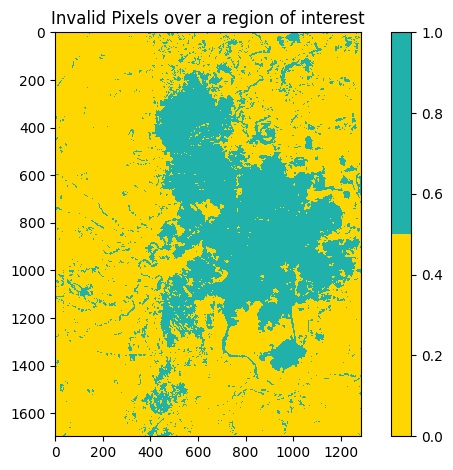

In [3]:
base_path = "/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570"
date = "2019-05-22"

cloud_dataset = rasterio.open(os.path.join(base_path, date, "cloud_mask.tif"))
clouds = cloud_dataset.read(1)
shadow_dataset = rasterio.open(os.path.join(base_path, date, "shadow_mask.tif"))
shadows = shadow_dataset.read(1)

result = np.logical_or(clouds, shadows)
result = result.astype(np.float32)

cmap = ListedColormap(["gold", "lightseagreen"])

plt.imshow(result, cmap=cmap)
plt.title("Invalid Pixels over a region of interest")
plt.colorbar()
plt.tight_layout()
plt.savefig("clouds_and_shadows.png", dpi=300)

In [4]:
height, width = result.shape

flood_result = result.copy()
flood_result[flood_result == 1] = -100

pixels = []

nelem = 0
for x in range(height):
    for y in range(width):
        if flood_result[x, y] == -100:
            nelem += 1
            num_filled_pixels, image, _, _ = cv2.floodFill(flood_result, None, (y, x), nelem, flags=8)
            # if num_filled_pixels < 50:
            #     flood_result[flood_result == nelem] = 0
            # else:
            flood_result[flood_result == nelem] = num_filled_pixels
            pixels.append(num_filled_pixels)
                
pixels = np.asarray(pixels)
pixels

array([ 83, 114, 285, ...,   8,  20,   6])

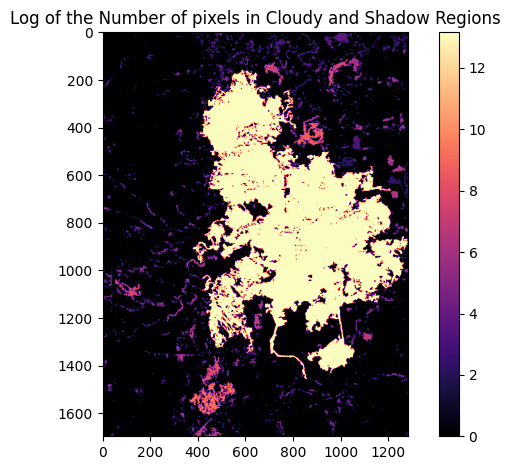

In [6]:
pixels.sort()

log_result = np.log(flood_result, out=np.zeros_like(flood_result), where=(flood_result != 0))
plt.imshow(log_result, cmap="magma",)
plt.title("Log of the Number of pixels in Cloudy and Shadow Regions")
plt.colorbar()
plt.tight_layout()
plt.savefig("flood_result.png", dpi=300)

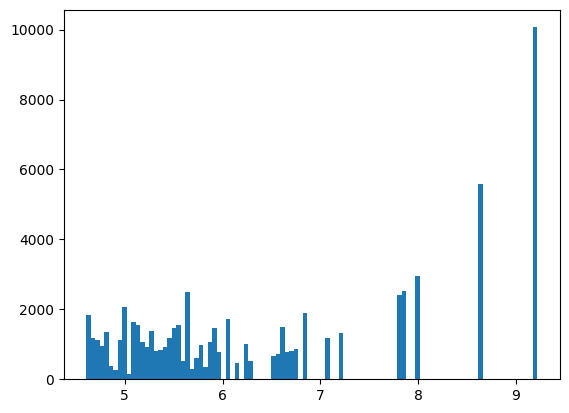

In [30]:
flattened_result = log_result.flatten()
flattened_result = flattened_result[flattened_result > 0] # Remove zero pixels -> They don't mean anything in our analysis
flattened_subset = flattened_result[flattened_result < max(flattened_result)]

plt.hist(flattened_subset, bins=100)
plt.show()

124050.055